# Notebook for creating Knowledge Graph embeddings from the REBEL extracted triplets using PyKeen model

Refer to the GitHub repo for more info: https://github.com/pykeen/pykeen

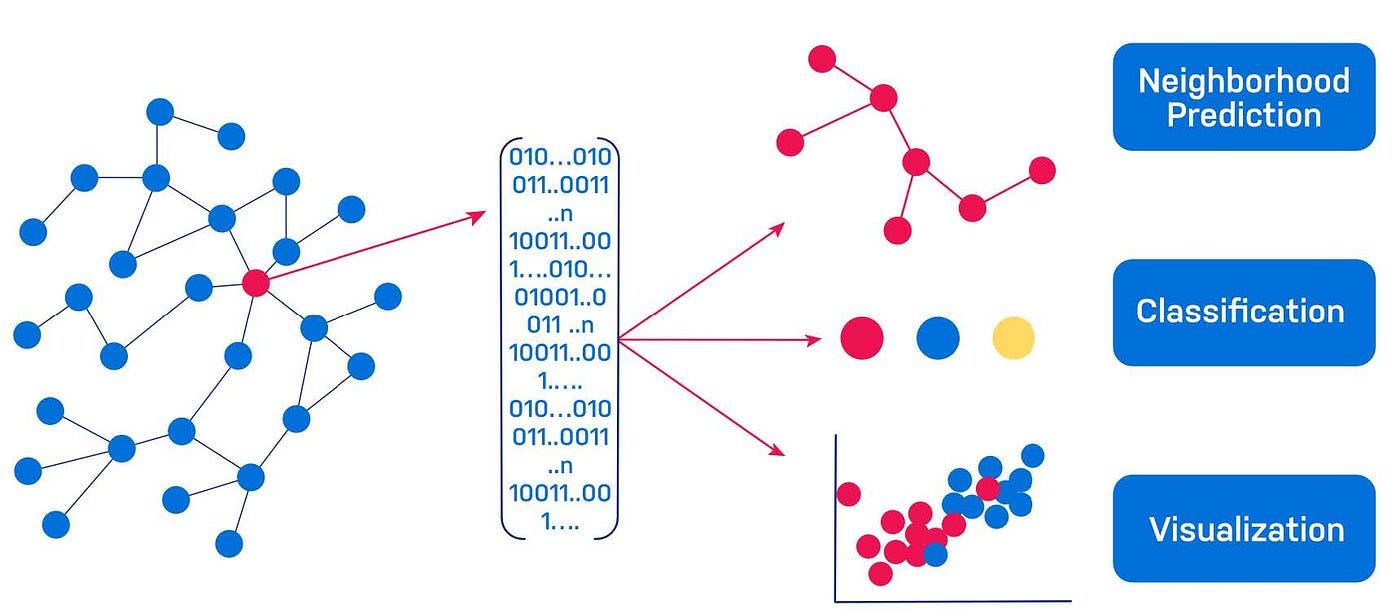

## Loading the kaggle triplet dataset

In [1]:
!kaggle datasets download -d agampy/text-triplets1k

Dataset URL: https://www.kaggle.com/datasets/agampy/text-triplets1k
License(s): apache-2.0
  0% 0.00/100k [00:00<?, ?B/s]
100% 100k/100k [00:00<00:00, 33.8MB/s]


In [2]:
!unzip /content/text-triplets1k.zip

Archive:  /content/text-triplets1k.zip
  inflating: text_triplets1k.csv     


In [3]:
import pandas as pd

triplets=pd.read_csv("/content/text_triplets1k.csv")
triplets.head()

,text,url,triplet
0,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing', 'type': 'subclass of..."
1,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'sub..."
2,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'has..."
3,['a brown leather recliner chair on a white ba...,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'recliner', 'type': 'subclass of', '..."
4,['a brown leather recliner chair on a white ba...,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'leather', 'type': 'subclass of', 't..."


In [8]:
triplets['triplet'].iloc[2996]

'[{\'head\': "\'a couple of men standing next to each other\'", \'type\': \'depicts\', \'tail\': "\'a couple of men standing next to each other\'"}]'

In [12]:
import ast

a=ast.literal_eval(triplets['triplet'].iloc[2996])
a[0]

{'head': "'a couple of men standing next to each other'",
 'type': 'depicts',
 'tail': "'a couple of men standing next to each other'"}

## Pre-processing to extract 'head' 'tail' and 'realtion' features as columns

In [17]:
import ast
import pandas as pd


def parse_triplet(triplet):

    if pd.isna(triplet) or not triplet:
        return None  # Return None to indicate this should be skipped

    try:

      parsed_triplet = ast.literal_eval(triplet)

      if parsed_triplet:

        parsed_triplet=parsed_triplet[0]
        # Check if parsed_triplet is a dictionary or a tuple
        if isinstance(parsed_triplet, dict):
            return parsed_triplet['head'], parsed_triplet['type'], parsed_triplet['tail']
        elif isinstance(parsed_triplet,tuple):
            return parsed_triplet[0]['head'], parsed_triplet[0]['type'], parsed_triplet[0]['tail']

    except (ValueError, SyntaxError) as e:
    # If there's an issue with parsing, skip the entry
         return (None,None,None)

triplets[['head','relation','tail']] = triplets['triplet'].apply(parse_triplet).apply(pd.Series)
triplets.head()

,text,url,triplet,head,relation,tail
0,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing', 'type': 'subclass of...",table sawing,subclass of,machine
1,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'sub...",table sawing machine,subclass of,white background
2,['a table sawing machine on a white background'],https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'has...",table sawing machine,has part,white background
3,['a brown leather recliner chair on a white ba...,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'recliner', 'type': 'subclass of', '...",recliner,subclass of,chair
4,['a brown leather recliner chair on a white ba...,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'leather', 'type': 'subclass of', 't...",leather,subclass of,chair


## Taking relevant columns for triplets and saving them as tsv file for PyKeen model

In [35]:
triplet_df = triplets[['head', 'relation', 'tail']]
triplet_df_train=triplet_df.sample(frac=0.8,random_state=25)
triplet_df_test=triplet_df.drop(triplet_df_train.index )

# Save to a tab-separated file
triplet_df.to_csv("/content/formatted_triplets.csv", sep='\t', index=False, header=False)
triplet_df_train.to_csv('text_triplet_train.csv', sep='\t', index=False)
triplet_df_test.to_csv('text_triplet_test.csv', sep='\t', index=False)

In [23]:
!pip install -q pykeen

## Training the PyKeen model for embeddings

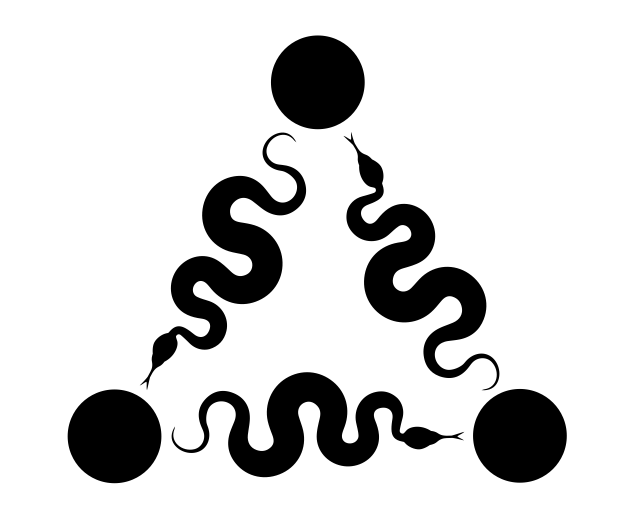

In [36]:
from pykeen.triples import TriplesFactory

training_triples_factory = TriplesFactory.from_path('/content/text_triplet_train.csv')
testing_triples_factory = TriplesFactory.from_path('/content/text_triplet_test.csv')

## Exxtracting the entity relation and subject for the pykeen model

In [25]:
d=training_triples_factory
id_to_entity_train={v: k for k, v in d.entity_to_id.items()}
id_to_relation_train={v: k for k, v in d.relation_to_id.items()}

e=testing_triples_factory
id_to_entity_test={v: k for k, v in e.entity_to_id.items()}
id_to_relation_test={v: k for k, v in e.relation_to_id.items()}

# Display the first few triples
training_triples_factory.triples[:5]

array([['', '', ''],
       ["'A sign that says home is where my plants are'", 'instance of',
        'sign'],
       ["'a bald man sitting on a set of stairs'", 'depicts',
        'bald man sitting on a set of stairs'],
       ["'a bald man sitting on a set of stairs'", 'depicts', 'stairs'],
       ["'a bedroom with a view of the water'", 'subclass of', 'bedroom']],
      dtype='<U139')

## Trainig TransE model with 100 epochs and a softplus loss function



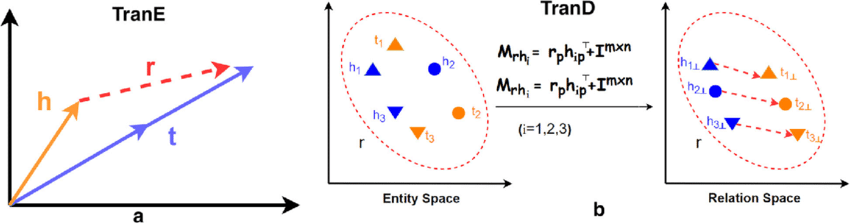

**The TransE model is one of the classical knowledge graph embedding techniques, and understanding it involves delving into how it represents and encodes entities and relations in a knowledge graph**

---

You can choose any of the model,dataset and loss function for training pykeen embeddings

- Find pre-existing datasets to train on - https://github.com/pykeen/pykeen?tab=readme-ov-file#datasets
- Select the best model based on embedding calculation method- https://github.com/pykeen/pykeen?tab=readme-ov-file#models

- Loss functions- https://github.com/pykeen/pykeen?tab=readme-ov-file#models

In [26]:
from pykeen.pipeline import pipeline

result = pipeline(
    model='TransE', #choose different graph embedding techniuqes
    loss="softplus",
    training=training_triples_factory,
    testing=testing_triples_factory,
    model_kwargs=dict(embedding_dim=3),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/567 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.54s seconds


In [27]:
model=result.model
model

TransE(
  (loss): SoftplusLoss(
    (margin_activation): Softplus(beta=1.0, threshold=20.0)
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(1669, 3)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(68, 3)
    )
  )
  (weight_regularizers): ModuleList()
)

## Evaluation metrics for KGE generated by the trained model

When evaluating knowledge graph embeddings, several metrics are commonly used to assess model performance. Here’s a brief description of each metric:

1. **Hits@K (Hit Rate at K):**
   - **Description:** Measures the proportion of times the correct entity (or relation) appears in the top K ranks of the model's predictions.
   - **Interpretation:** Higher values indicate better performance. For example, **Hits@1** evaluates whether the correct entity is the top-ranked prediction, while **Hits@10** checks if it is among the top 10 predictions.
   - **Usage:** Hits@1, Hits@3, Hits@5, Hits@10 are standard benchmarks to understand how often the model correctly predicts the entity or relation within the top K positions.

2. **Mean Reciprocal Rank (MRR):**
   - **Description:** Calculates the average of the reciprocal ranks of the first correct prediction across all queries. Reciprocal rank is defined as
   \`( \frac{1}{\text{rank}} \)`  where rank is the position of the first correct result.
   - **Interpretation:** Higher values signify that correct predictions appear at higher ranks on average. MRR is useful for assessing how well the model ranks the correct answers relative to incorrect ones.

In [28]:
from pykeen.evaluation import RankBasedEvaluator

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing_triples_factory.mapped_triples, additional_filter_triples=[training_triples_factory.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cpu:   0%|          | 0.00/567 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Hits@1: 0.0
Hits@3: 0.0008818342151675485
Hits@5: 0.004409171075837742
Hits@10: 0.009700176366843033
Mean Reciprocal Rank: 0.005238705780357122


## Visualisatuion of the generated embeddings and corresponding knowledge graph with plotly graph objects

In [29]:

import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)

# Get entity embeddings and transform them to 2D
entity_embeddings = model.entity_representations[0](indices=None).cpu().detach().numpy()
entity_pca = pca.fit_transform(entity_embeddings)

# Create a scatter plot for entities
entity_trace = go.Scatter(
    x=entity_pca[:, 0],
    y=entity_pca[:, 1],
    mode='markers+text',
    name='Entities',
    text=[id_to_entity_train[i] for i in range(len(id_to_entity_train))],  # Ensure this maps correctly
    marker=dict(color='blue', size=8),  # Adjust size for clarity
    textposition="top center"
)

# Get relation embeddings and transform them to 2D
relation_embeddings = model.relation_representations[0](indices=None).cpu().detach().numpy()
relation_pca = pca.transform(relation_embeddings)

# Create a scatter plot for relations
relation_trace = go.Scatter(
    x=relation_pca[:, 0],
    y=relation_pca[:, 1],
    mode='markers+text',
    name='Relations',
    text=[id_to_relation_train[i] for i in range(len(id_to_relation_train))],  # Ensure this maps correctly
    marker=dict(color='red', size=10),  # Adjust size for clarity
    textposition="bottom center"
)

# Create arrows and labels for relations
relation_arrows = []
annotations = []
entity_id_to_index = {name: idx for idx, name in enumerate(id_to_entity_train.values())}  # Assuming id_to_entity_train is a dict

for triple in training_triples_factory.triples:
    subject, relation, object_ = triple
    subject_index = entity_id_to_index.get(subject, None)
    object_index = entity_id_to_index.get(object_, None)

    if subject_index is not None and object_index is not None:
        x_start, y_start = entity_pca[subject_index]
        x_end, y_end = entity_pca[object_index]

        # Add arrows (lines) between entities
        relation_arrows.append(
            go.Scatter(
                x=[x_start, x_end],
                y=[y_start, y_end],
                mode='lines',
                line=dict(color='red', width=2),
                showlegend=False
            )
        )

        # Add labels for the relations
        mid_x = (x_start + x_end) / 2
        mid_y = (y_start + y_end) / 2
        annotations.append(
            go.layout.Annotation(
                x=mid_x,
                y=mid_y,
                text=relation,
                showarrow=False,
                font=dict(color='red', size=10),
                xref="x",
                yref="y",
                align="center"
            )
        )
    else:
        print(f"Entity '{subject}' or '{object_}' not found in the entity index mapping.")

# Combine the plots
layout = go.Layout(
    title="Knowledge Graph Embeddings Visualization",
    xaxis=dict(title='PCA Component 1'),
    yaxis=dict(title='PCA Component 2'),
    showlegend=True,
    width=1600,
    height=1600,
    annotations=annotations,  # Add annotations for relation labels
    autosize=False,
    margin=dict(l=0, r=0, t=40, b=0),  # Adjust margins for better fit
)

# Create the figure and plot it
fig = go.Figure(data=[entity_trace, relation_trace] + relation_arrows, layout=layout)
fig.show()


## Saving the reduced Knowledge Graph embeddings

In [30]:
triplet_df = triplets[['head', 'relation', 'tail']]
triplet_df_train=triplet_df.sample(frac=0.8,random_state=25)
triplet_df_test=triplet_df.drop(triplet_df_train.index )

# Save to a tab-separated file
triplet_df.to_csv("/content/formatted_triplets1k.txt", sep='\t', index=False, header=False)
triplet_df_train.to_csv('text_triplet_train1k.txt', sep='\t', index=False)
triplet_df_test.to_csv('text_triplet_test1k.txt', sep='\t', index=False)


from pykeen.triples import TriplesFactory

training_triples_factory = TriplesFactory.from_path('/content/text_triplet_train1k.txt')
testing_triples_factory = TriplesFactory.from_path('/content/text_triplet_test1k.txt')

d=training_triples_factory
id_to_entity_train={v: k for k, v in d.entity_to_id.items()}
id_to_relation_train={v: k for k, v in d.relation_to_id.items()}

e=testing_triples_factory
id_to_entity_test={v: k for k, v in e.entity_to_id.items()}
id_to_relation_test={v: k for k, v in e.relation_to_id.items()}

# Display the first few triples
training_triples_factory.triples

from pykeen.pipeline import pipeline

result = pipeline(
    model='TransE',
    loss="softplus",
    training=training_triples_factory,
    testing=testing_triples_factory,
    model_kwargs=dict(embedding_dim=3),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)

model=result.model

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/567 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.55s seconds


In [32]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


In [33]:
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

entity_embeddings = model.entity_representations[0](indices=None).cpu().detach().numpy()
relation_embeddings=model.relation_representations[0](indices=None).cpu().detach().numpy()


pca = PCA(n_components=3)
pca_result = pca.fit_transform(entity_embeddings)

umap_model = umap.UMAP(n_components=3)
umap_result = umap_model.fit_transform(entity_embeddings)

tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(entity_embeddings)



In [34]:
# Convert to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['pca_x','pca_y','pca_z'])
umap_df = pd.DataFrame(umap_result, columns=['umap_x','umap_y','umap_z'])
tsne_df = pd.DataFrame(tsne_result, columns=['tsne_x','tsne_y','tsne_z'])

# Save to CSV
pca_df.to_csv('pca_text_kgembeddings.csv', index=False)
umap_df.to_csv('umap_text_kgembeddings.csv', index=False)
tsne_df.to_csv('tsne_text_kgembeddings.csv', index=False)
